In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate
import math 

sub_dir = 'analysis/pka_data'
directory_1 = os.path.join(sub_dir)

# Get the list of files in each directory
files = [f for f in os.listdir(directory_1) if f.endswith('_exp.dat')]

# Lists to store data from all files
all_data = []

for file in files:
    name = file.split('_')[0]
    file_1 = os.path.join(directory_1, file)
    
    try:
        data_1 = pd.read_csv(file_1, delim_whitespace=True)  # Use delim_whitespace=True to handle multiple spaces as delimiter
    except:
        print('Error reading file:', file_1)
        continue
    

    # Assuming 'pKa' and 'exp_pKa' are columns in data_1
    pKa_values = data_1['pka']
    exp_pKa_values = data_1['exp_pKa']
    resnames = data_1['resname']

    # print(resnames)
    # Combine data from the current file into a single DataFrame
    combined_data = pd.DataFrame({
        'pKa': pKa_values,
        'exp_pKa': exp_pKa_values,
        'Resname': resnames
    })

    
    # Append the combined data to the list
    all_data.append(combined_data)
    

# Concatenate data from all files into a single DataFrame
combined_all_data = pd.concat(all_data, ignore_index=True)

# Calculate RMSD, MAE, and R-squared (R²) values with direction for each unique 'resname'
results_by_resname = {}
results_all = {}
#mask - no SER or TYR
combined_all_data = combined_all_data[combined_all_data['Resname'] != 'SER']
pKa_values = combined_all_data['pKa']
exp_pKa_values = combined_all_data['exp_pKa']
rmsd = np.sqrt(mean_squared_error(exp_pKa_values, pKa_values))
mae = mean_absolute_error(exp_pKa_values, pKa_values)
mean_signed_diff = np.mean(pKa_values - exp_pKa_values)
r2 = r2_score(exp_pKa_values, pKa_values)
MSE = mean_squared_error(exp_pKa_values, pKa_values)
MAE = mean_absolute_error(exp_pKa_values, pKa_values)
AIC = 2 - 2 * np.log(MSE)
Pearson = np.corrcoef(exp_pKa_values, pKa_values)[0,1]
table_data = [[f'All({exp_pKa_values.shape[0]})', math.sqrt(MSE), mae, mean_signed_diff, r2, AIC, Pearson]]
for unique_resname in combined_all_data['Resname'].unique():
    # if unique_resname == 'SER':
    #     continue
    mask = combined_all_data['Resname'] == unique_resname
    pKa_values_resname = combined_all_data[mask]['pKa']
    exp_pKa_values_resname = combined_all_data[mask]['exp_pKa']

    # Calculate differences between pKa and exp_pKa with direction
    differences = pKa_values_resname - exp_pKa_values_resname

    # Calculate squared differences between pKa and exp_pKa
    squared_diff = differences ** 2

    # Calculate the mean squared difference
    mean_squared_diff = np.mean(squared_diff)

    # Calculate the RMSD
    rmsd = np.sqrt(mean_squared_diff)
    
    r2 = r2_score(exp_pKa_values_resname, pKa_values_resname)

    # Calculate the Mean Absolute Error (MAE) with direction
    mae = np.mean(np.abs(differences))
    
    MSE = mean_squared_error(exp_pKa_values_resname, pKa_values_resname)
    MAE = mean_absolute_error(exp_pKa_values_resname, pKa_values_resname)

    if differences.shape[0] == 1:
        mean_signed_diff = differences.values[0]
    else:
        mean_signed_diff = np.mean(differences)
       

    # Calculate the R-squared (R²) value
    r_squared = r2_score(exp_pKa_values_resname, pKa_values_resname)
    Pearson = np.corrcoef(exp_pKa_values_resname, pKa_values_resname)[0,1]
    AIC = 2 - 2 * np.log(MSE)
    # if r2 < -1 or r2 > 1 or np.isnan(r2):
    #     r2 = ''
    # else:
    #     r2 = round(r2, 2)
    # Store results in the dictionary
    results_by_resname[unique_resname] = {
        'amount': pKa_values_resname.shape[0],
        'RMSD': math.sqrt(MSE),
        'MAE': MAE,
        'MSD': mean_signed_diff,
        'R-squared': r2,
        'AIC': AIC,
        'Pearson': Pearson
    }

# Create a table of results
for resname, res_results in results_by_resname.items():
    length = res_results['amount']
    table_data.append([f'{resname}({length})', res_results['RMSD'], res_results['MAE'], res_results['MSD'], res_results['R-squared'], res_results['AIC'], res_results['Pearson']])
    


# Define table headers
headers = ['Resname', 'RMSD', 'Mean Abs. Error', 'Mean Signed Error', 'R-squared', 'AIC', 'Pearson']

# Print the table
table_str = tabulate(table_data, headers, tablefmt='simple', floatfmt='.2f')
print(table_str)

Resname      RMSD    Mean Abs. Error    Mean Signed Error    R-squared    AIC    Pearson
---------  ------  -----------------  -------------------  -----------  -----  ---------
All(210)     1.17               0.84                 0.26         0.84   1.36       0.93
GLU(77)      1.17               0.86                 0.50        -1.93   1.39       0.48
ASP(74)      1.18               0.84                 0.15         0.37   1.34       0.79
HSP(31)      1.38               1.03                -0.22        -0.60   0.72       0.75
TYR(16)      1.05               0.70                 0.37         0.39   1.82       0.79
LYS(12)      0.67               0.45                 0.42        -1.98   3.61       0.28


1ubq
2trx
4pti
1beg
1rgg
7rsa
4lzt
1de3
1vii
1stn
1ygw
1bvi
1trw
1w4h
1goa


<Figure size 640x480 with 0 Axes>

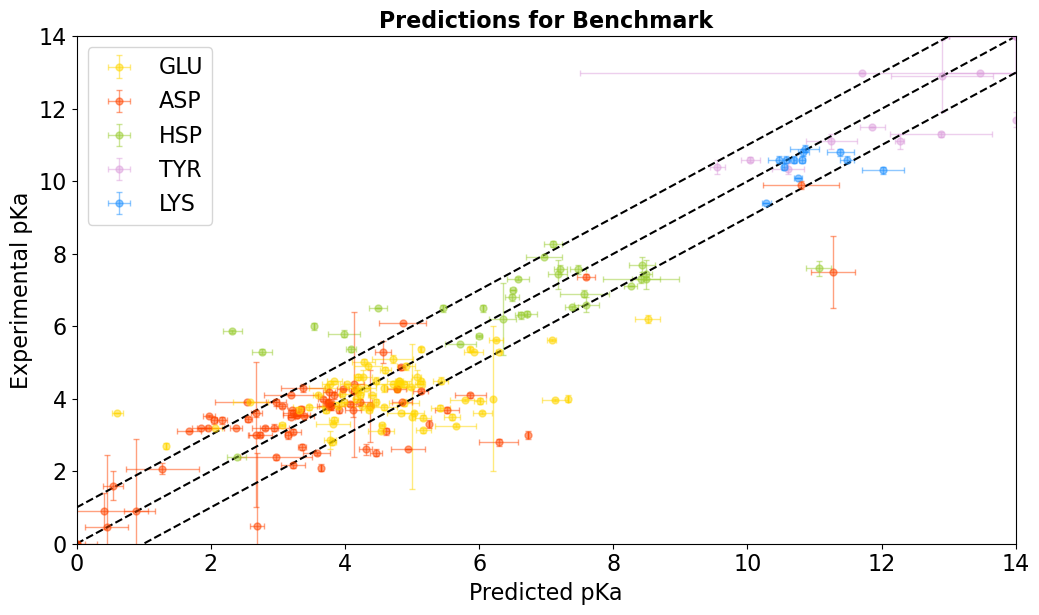

In [2]:
import matplotlib.pyplot as plt
import matplotlib

color_scheme = {
    'ASP': 'orangered',
    'GLU': 'gold',
    'LYS': 'dodgerblue',
    'TYR': 'plum',
    'HSP': 'yellowgreen',
    'CYS': 'yellow',
    'SER': 'royalblue',
}

font_all = 16
matplotlib.rcParams['font.family'] = 'sans-serif'
min_all = 0
max_all = 14
plt.tight_layout()

out_dir = 'analysis/'


fig_all,ax_all = plt.subplots(figsize=(10.5,6.25))
label_trs = []
all_labels = []
for file in files:
    max_value = 0
    name = file.split('_')[0]
    print(name)
    
    file_1 = os.path.join(directory_1, file)
    file_2 = os.path.join(os.path.dirname(directory_1), 'exp_pka', name + '.txt')
    try:
        data_1 = pd.read_csv(file_1, delim_whitespace=True)
    except:
        print('Error reading file: ', file_1)
        continue

    try:
        data_2 = pd.read_csv(file_2, delim_whitespace=True)
    except:
        print('Error reading file: ', file_2)
        continue
    
    data_1.columns = [col.replace(' ', '') for col in data_1.columns]
    data_2.columns = [col.replace(' ', '') for col in data_2.columns]
   
    # Replace all big letters in column names with small ones
    data_1.columns = [col.lower() for col in data_1.columns]
    data_2.columns = [col.lower() for col in data_2.columns]

    # print(data_2)

    fig,ax = plt.subplots(figsize=(16,9))
    
    labels = []
    single_font = 16
    
    # All resids from data_1 and data_2
    resids = list(set(data_1['resid'].values))
    min, max = 0, 0
    for resid in resids:
        resname = data_1[data_1['resid'] == resid]['resname'].values[0].split()[0]
        if resname == 'SER':
            continue
        pKa = float(data_1[data_1['resid'] == resid]['pka'].values[0])
        pKa_err = float(data_1[data_1['resid'] == resid]['pka_err'].values[0])

        # a = 1
        # V_mod = model[resname][0]**3# - model[resname][2])
        # V_prot =prot[name][0]**3# - prot[name][2]) # 4*math.sqrt(3)/9
        # corr = a* (2*pi/3) * (k * gamma / (R * T * math.log(10))) * ((prot[name][1]/V_prot) - (model[resname][1]/V_mod))
        # corr2 = 0
        # corr2 = -0.3
            

        
        # corr += corr2
        
        # pKa = pKa + corr2
        pKa_exp = float(data_1[data_1['resid'] == resid]['exp_pka'].values[0])
        pKa_exp_err = float(data_1[data_1['resid'] == resid]['exp_pka_err'].values[0])
        # Check that other file has the same value
        
        # print(pKa, pKa_exp)
        del_pKa = float(data_1[data_1['resid'] == resid]['∆pka'].values[0])
        del_pKa_err = float(data_1[data_1['resid'] == resid]['∆pka_err'].values[0])
        
        # sasa = float(data_2[data_2['resid'] == resid]['sasa'].values[0])
        # if sasa > 100:
            # sasa = 100
            
        # pKa = pKa * math.exp(-0.0005 * sasa)
        if f'{resname} {name}' not in label_trs:
            label_trs.append(f'{resname} {name}')
            label_tr = f'{resname} {name}'
        else:
            label_tr = None
            
        if resname not in all_labels:
            all_labels.append(resname)
            all_label = resname
        else:
            all_label = None
            
        if resname not in labels:
            labels.append(resname)
            label_s = resname
        else:
            label_s = None
                    
        if pKa > max:
            max = pKa
        if pKa < min:
            min = pKa
        if pKa_exp > max:
            max = pKa_exp
        if pKa_exp < min:
            min = pKa_exp
            
        # lzt = ['1lsa','2lzt','4lzt']
        markers = ['o','s','^']
        # if name in lzt:
        #     marker_h = markers[lzt.index(name)]
            # ax_all.errorbar(pKa,pKa_exp, xerr=pKa_err, yerr=pKa_exp_err, fmt=marker_h, alpha=0.5, color = color_scheme[resname], label=label_tr, markersize=font_all/2, mfc='none', mew=2)
        ax_all.errorbar(pKa,pKa_exp, xerr=pKa_err, yerr=pKa_exp_err,fmt='o', alpha=0.5, color = color_scheme[resname], label=all_label, markersize=5, elinewidth=1, capsize=2)
        ax.errorbar(pKa,pKa_exp, xerr=pKa_err, yerr=pKa_exp_err, fmt='o', alpha=0.9, color = color_scheme[resname], label=label_s, markersize=10)
    # symetrical plot 
    ax.set_xlim([0,14])
    ax.set_ylim([0,14])
    min, max = 0, 14
    # ax.set_xlabel(f'Predicted pKa', fontsize=single_font)
    # ax.set_ylabel(f'Experimental pKa', fontsize=single_font)
    ax.set_title(f'{name}', fontsize=single_font*2, fontweight='bold')
    # plot y = x
    ax.plot([min,max], [min,max], color='k', linestyle='--')
    #dashed x = y + 1
    ax.plot([min,max], [min+1,max+1], color='k', linestyle='--')
    #dashed x = y - 1
    ax.plot([min,max], [min-1,max-1], color='k', linestyle='--')
    ax.legend(loc='best', fontsize=single_font)
    #font size 
    ax.tick_params(axis='both', which='major', labelsize=single_font)
    fig.savefig(f'{out_dir}/{name}_delta_pKa.pdf', bbox_inches='tight')
    plt.close(fig)
ax_all.tick_params(axis='both', which='major', labelsize=font_all)

ax_all.set_ylim([0,14])
ax_all.set_xlim([0,14])
ax_all.set_xlabel('Predicted pKa', fontsize=font_all)
ax_all.set_ylabel(f'Experimental pKa', fontsize=font_all)
ax_all.set_title('Predictions for Benchmark', fontsize=font_all, fontweight='bold')
ax_all.legend(loc='best', fontsize=font_all)
# fig_all.patch.set_facecolor('#CDD8DC')
fig_all.patch.set_alpha(0)
fig_all.tight_layout()
ax_all.set_facecolor('white')
# plot y = x
ax_all.plot([min_all,max_all], [min_all,max_all], color='k', linestyle='--')
#plot y = x + 1 dashed
ax_all.plot([min_all,max_all], [min_all+1,max_all+1], color='k', linestyle='--')
#plot y = x - 1 dashed
ax_all.plot([min_all,max_all], [min_all-1,max_all-1], color='k', linestyle='--')
fig_all.savefig(f'{out_dir}/all_delta_pKa.pdf', bbox_inches='tight')